In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score

In [112]:
df_1 = pd.read_csv('heart_failure/train_val_split.csv')
df_2 = pd.read_csv('heart_failure/test_split.csv')
df = df_1.append(df_2, ignore_index=True)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [113]:
print(df.head())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   37   M           ATA        130          283          0         ST     98   
2   48   F           ASY        138          214          0     Normal    108   
3   54   M           NAP        150          195          0     Normal    122   
4   39   M           NAP        120          339          0     Normal    170   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      0.0       Up             0  
2              Y      1.5     Flat             1  
3              N      0.0       Up             0  
4              N      0.0       Up             0  


In [114]:
continuos = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
binary = ["Sex", "FastingBS", "ExerciseAngina"]
categorical = ["ChestPainType", "RestingECG", "ST_Slope"]

In [115]:
df.shape

(918, 12)

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [117]:
df.isna().all()

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool

In [118]:
df[continuos].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


<Figure size 800x550 with 0 Axes>

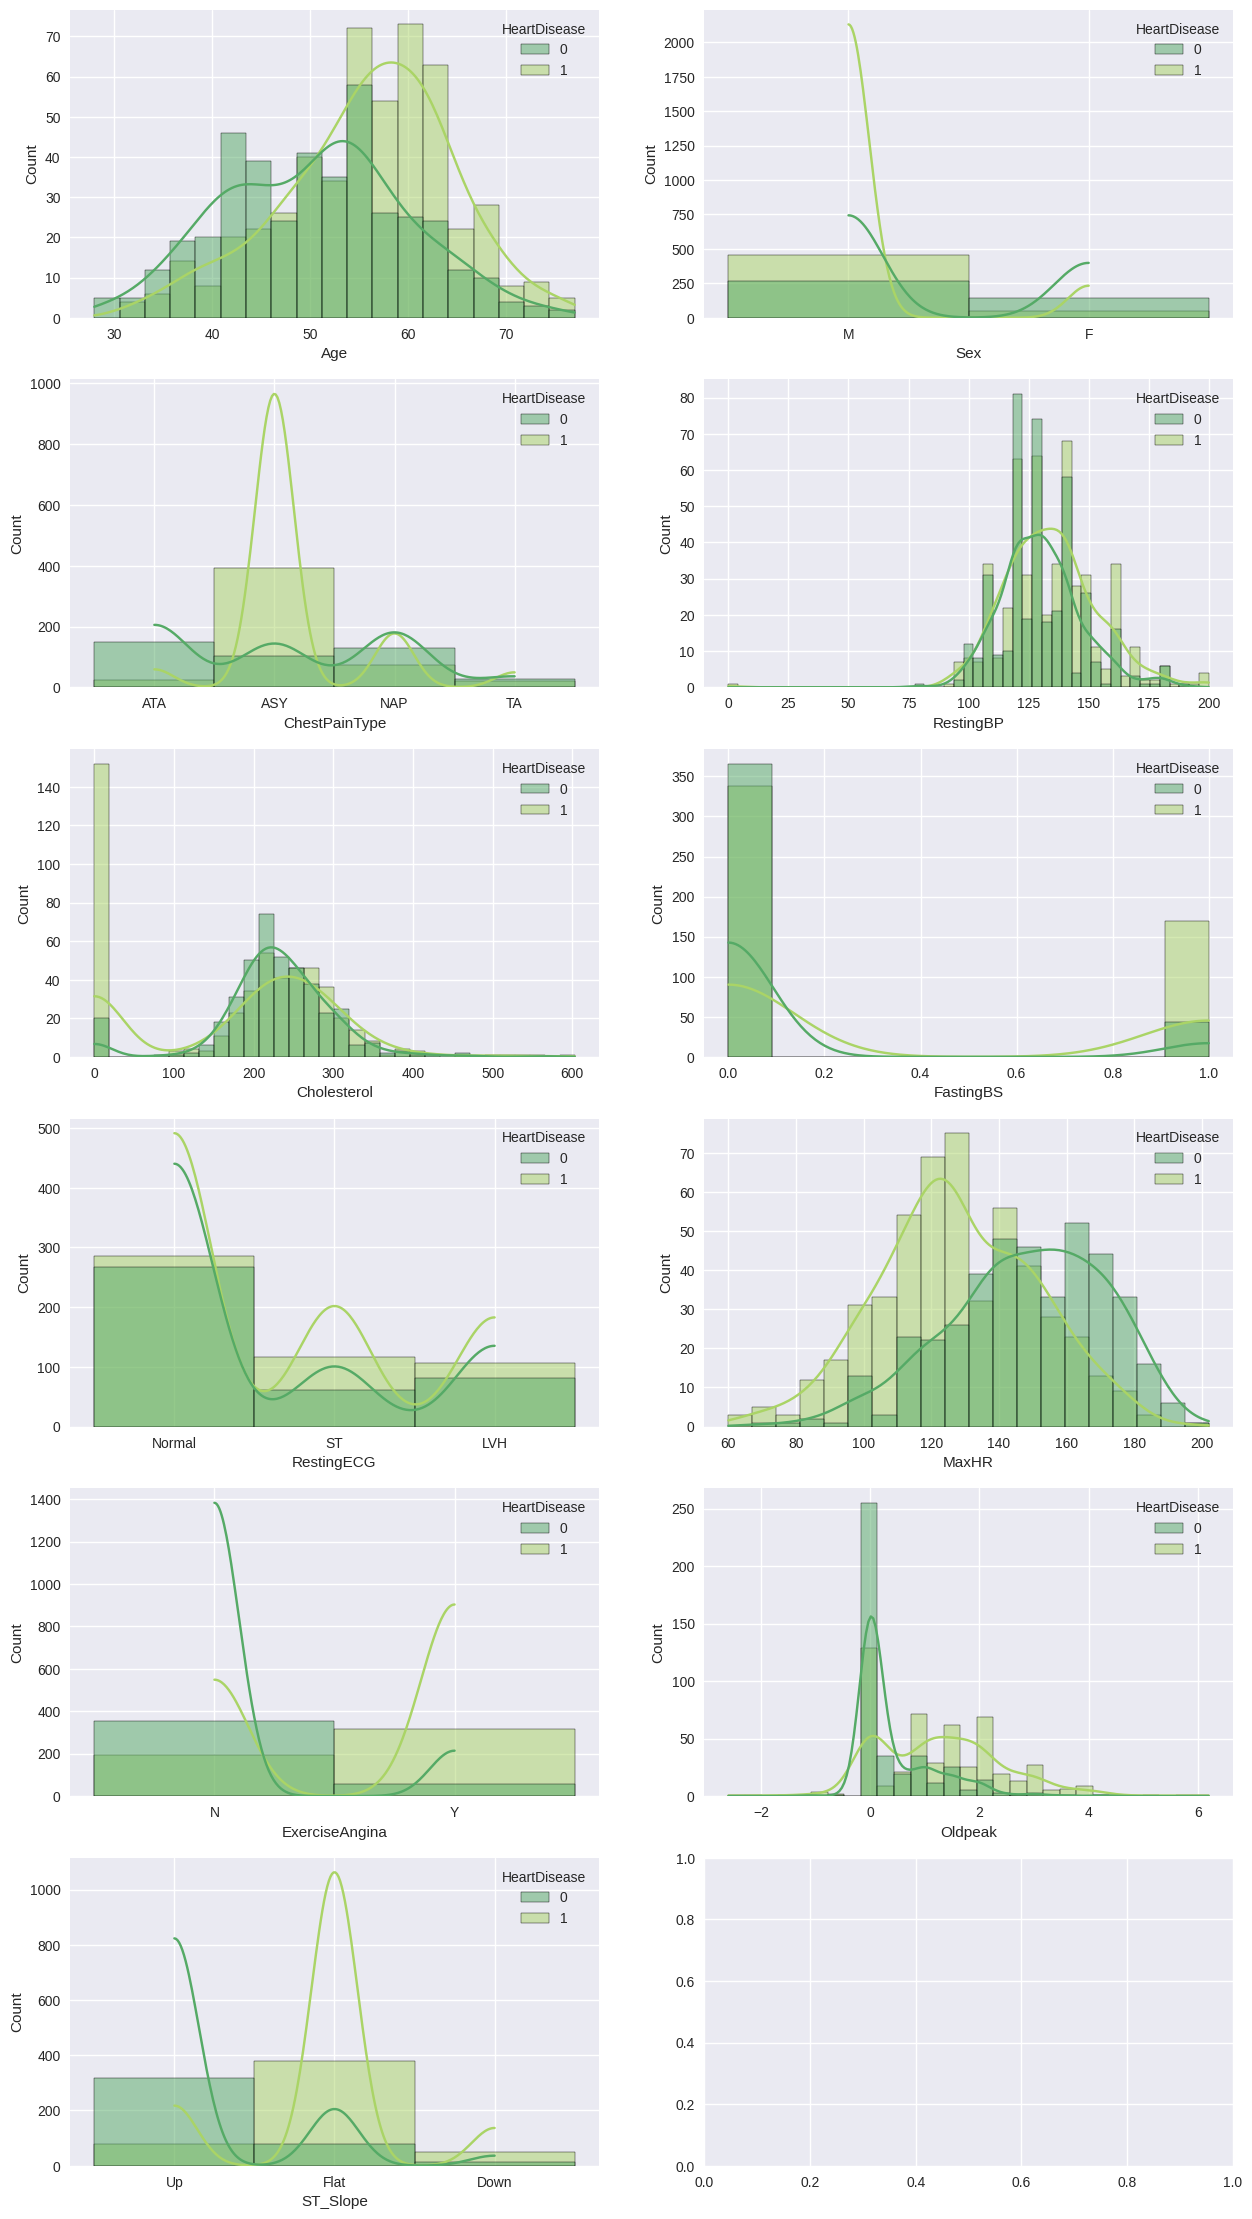

In [119]:
plt.style.use("seaborn")
plt.subplots_adjust(hspace=0.2)
color = 'summer'

fig, axs = plt.subplots(6, 2, figsize=(15,28))
i=1
for feature in df.columns:
    if feature not in ["HeartDisease"] and i < 14:
        plt.subplot(6,2,i)
        sns.histplot(data=df, x=feature, kde=True, palette=color, hue='HeartDisease')
        i+=1

In [120]:
def detect_outliers(label=None):
    Q1 = df[label].quantile(0.25)
    Q3 = df[label].quantile(0.75)
    IQR = Q3 - Q1
    interval = ((df[label] > Q1 - 1.5*IQR) & (df[label] < Q3 + 1.5*IQR))
    return df[interval], df[~interval]

In [121]:
def assign_mean(df_out, not_df_out, label=None):
    df.loc[df_out[df_out["HeartDisease"] == 0].index, label] = not_df_out[not_df_out["HeartDisease"] == 0][label].mean()
    df.loc[df_out[df_out["HeartDisease"] == 1].index, label] = not_df_out[not_df_out["HeartDisease"] == 1][label].mean()
    return

In [122]:
def delete_outliers(df_out):
    return df.drop(df_out.index)

<Axes: xlabel='Cholesterol'>

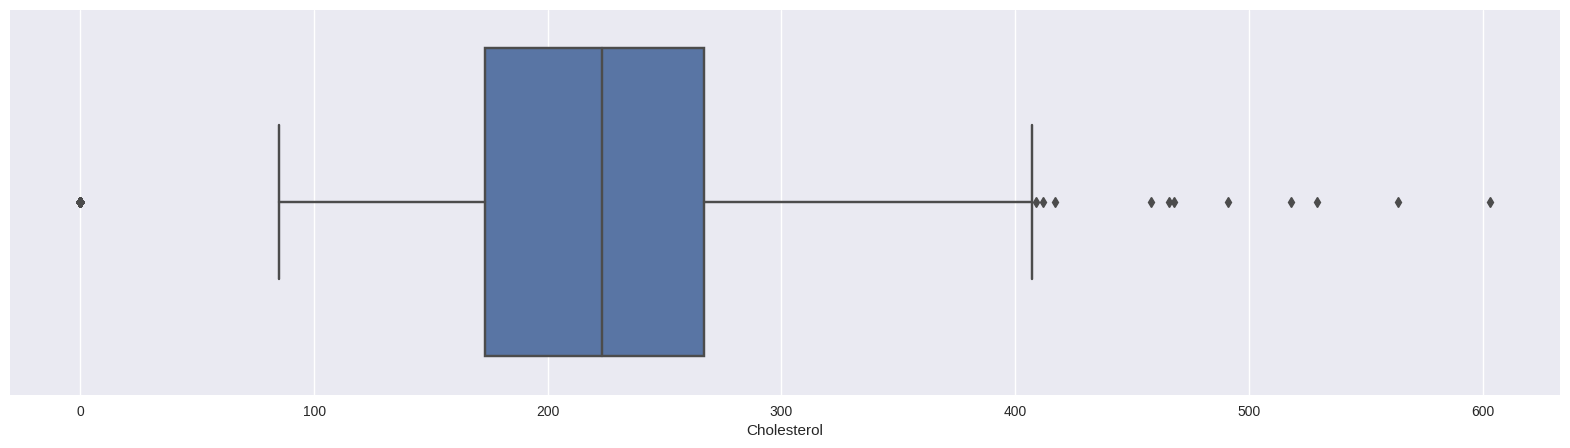

In [123]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df, x="Cholesterol")

In [124]:
not_df_out_ch, df_out_ch = detect_outliers('Cholesterol')
print(f'Outliers in cholesterol represent the {round((df_out_ch.shape[0]*100)/df.shape[0], 2)}% of our dataset')
df_out_ch

Outliers in cholesterol represent the 19.93% of our dataset


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
24,53,F,ATA,113,468,0,Normal,127,N,0.0,Up,0
26,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1
59,44,M,ASY,150,412,0,Normal,170,N,0.0,Up,0
64,32,M,ASY,118,529,0,Normal,130,N,0.0,Flat,1
201,44,M,ASY,135,491,0,Normal,135,N,0.0,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
883,38,M,NAP,100,0,0,Normal,179,N,-1.1,Up,0
889,52,M,ASY,130,0,1,Normal,120,N,0.0,Flat,1
898,60,M,ASY,160,0,0,ST,99,Y,0.5,Flat,1
901,58,M,ASY,116,0,0,Normal,124,N,1.0,Up,1


<Axes: xlabel='Cholesterol', ylabel='Count'>

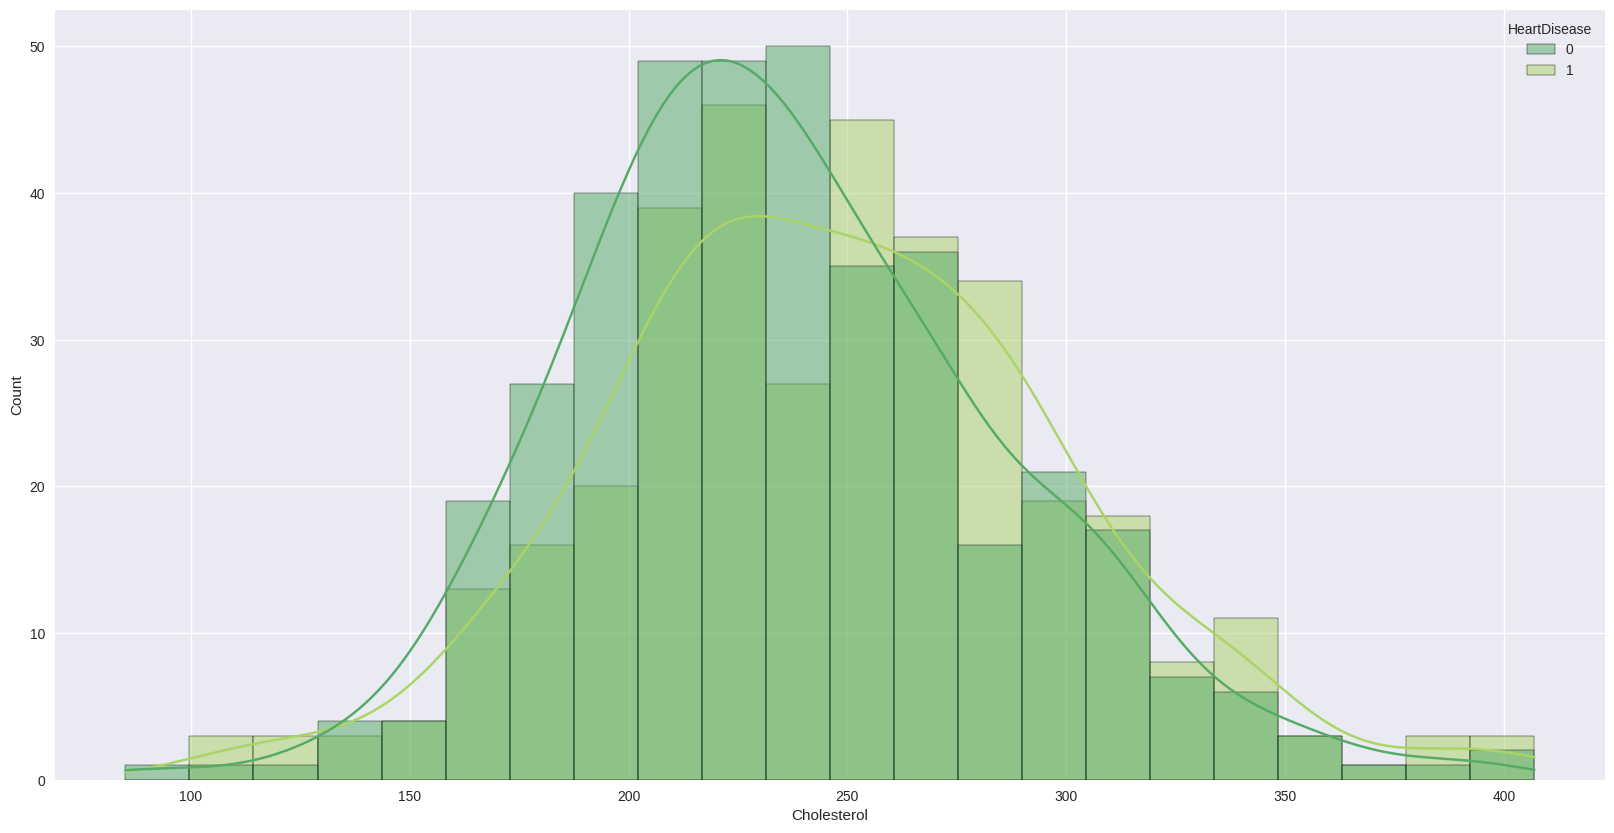

In [125]:
df = delete_outliers(df_out_ch[df_out_ch["Cholesterol"] == 0])
assign_mean(df_out_ch[df_out_ch["Cholesterol"] != 0], not_df_out_ch, 'Cholesterol')

plt.figure(figsize=(20,10))
sns.histplot(data=df, x='Cholesterol', kde=True, palette=color, hue='HeartDisease')

<Axes: xlabel='RestingBP'>

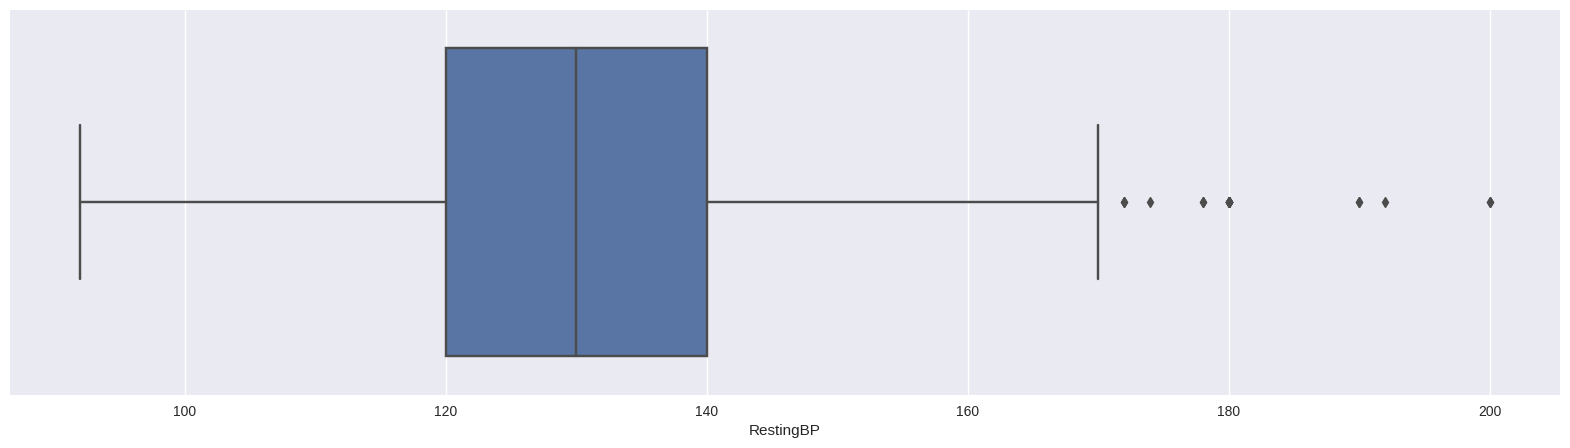

In [126]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df, x="RestingBP")

In [127]:
not_df_out_rbp, df_out_rbp = detect_outliers('RestingBP')
print(f'Outliers in resting blood pressure represent the {round((df_out_rbp.shape[0]*100)/df.shape[0], 2)}% of our dataset')
df_out_rbp

Outliers in resting blood pressure represent the 4.29% of our dataset


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
72,65,M,ASY,170,263.0,1,Normal,112,Y,2.0,Flat,1
89,39,M,ATA,190,241.0,0,Normal,106,N,0.0,Up,0
100,58,F,ATA,180,393.0,0,Normal,110,Y,1.0,Flat,1
108,56,M,ASY,170,388.0,0,ST,122,Y,2.0,Flat,1
156,53,M,ASY,180,285.0,0,ST,120,Y,1.5,Flat,1
157,46,M,ASY,180,280.0,0,ST,120,N,0.0,Up,0
176,30,F,TA,170,237.0,0,ST,170,N,0.0,Up,0
222,45,F,ATA,180,295.0,0,Normal,180,N,0.0,Up,0
223,59,M,NAP,180,213.0,0,Normal,100,N,0.0,Up,0
225,57,F,ASY,180,347.0,0,ST,126,Y,0.8,Flat,0


<Axes: xlabel='RestingBP', ylabel='Count'>

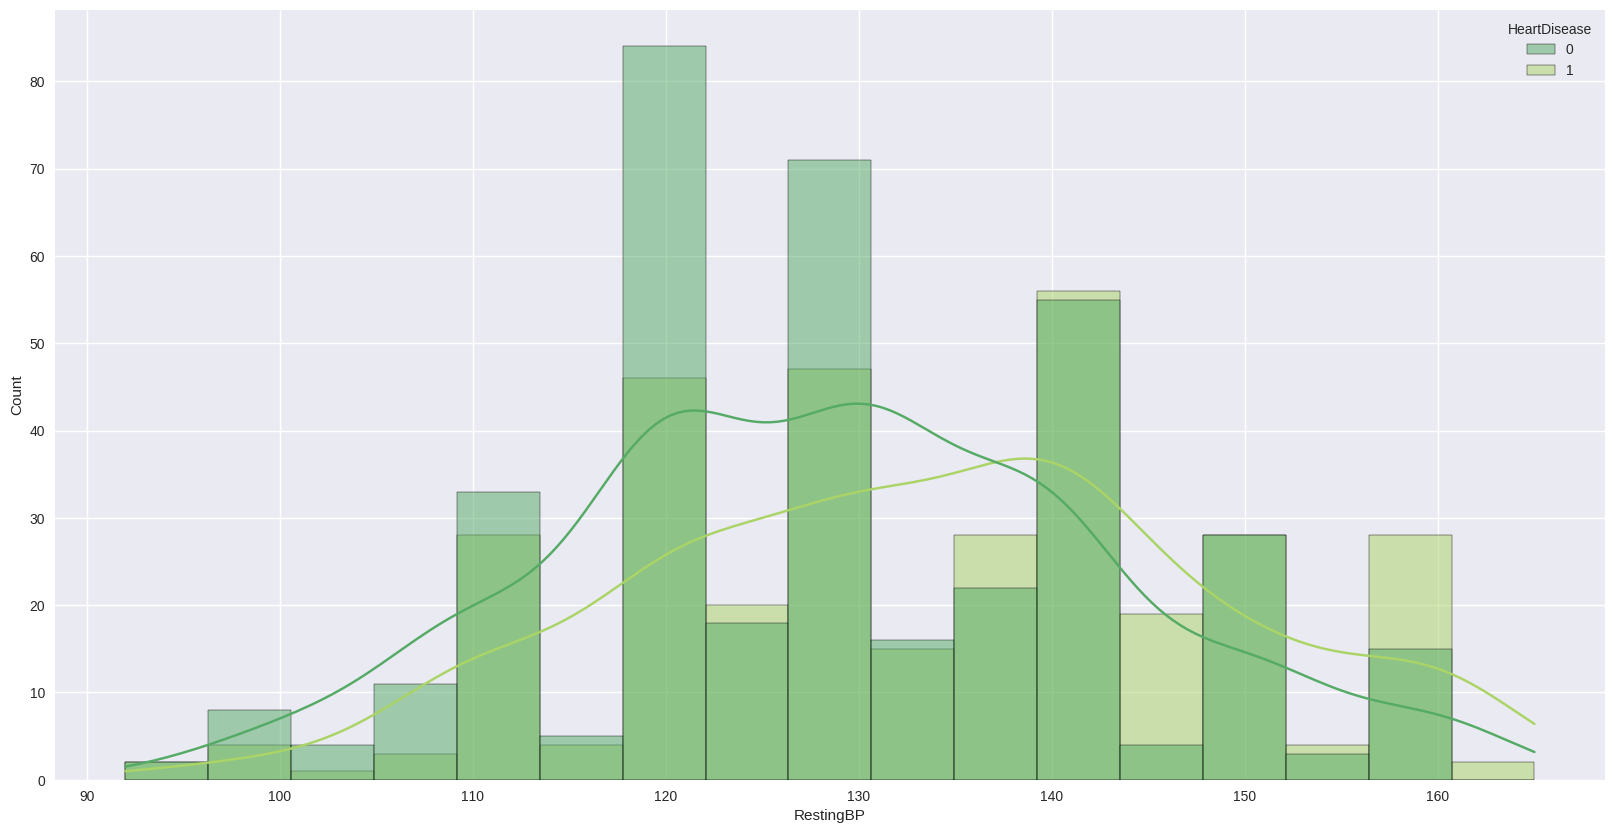

In [128]:
df = delete_outliers(df_out_rbp)
plt.figure(figsize=(20,10))
sns.histplot(data=df, x='RestingBP', kde=True, palette=color, hue='HeartDisease')

In [129]:
col = list(df.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(df[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


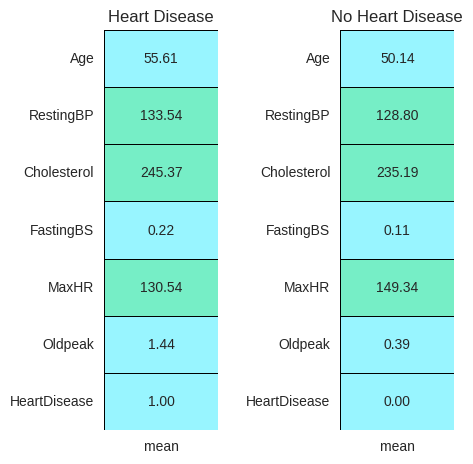

In [130]:
colors = ['#98F5FF','#76EEC6']
yes = df[df['HeartDisease'] == 1].describe().T
no = df[df['HeartDisease'] == 0].describe().T

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(yes[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f',)
plt.title('Heart Disease');

plt.subplot(1,2,2)
sns.heatmap(no[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('No Heart Disease');

fig.tight_layout(pad = 2)

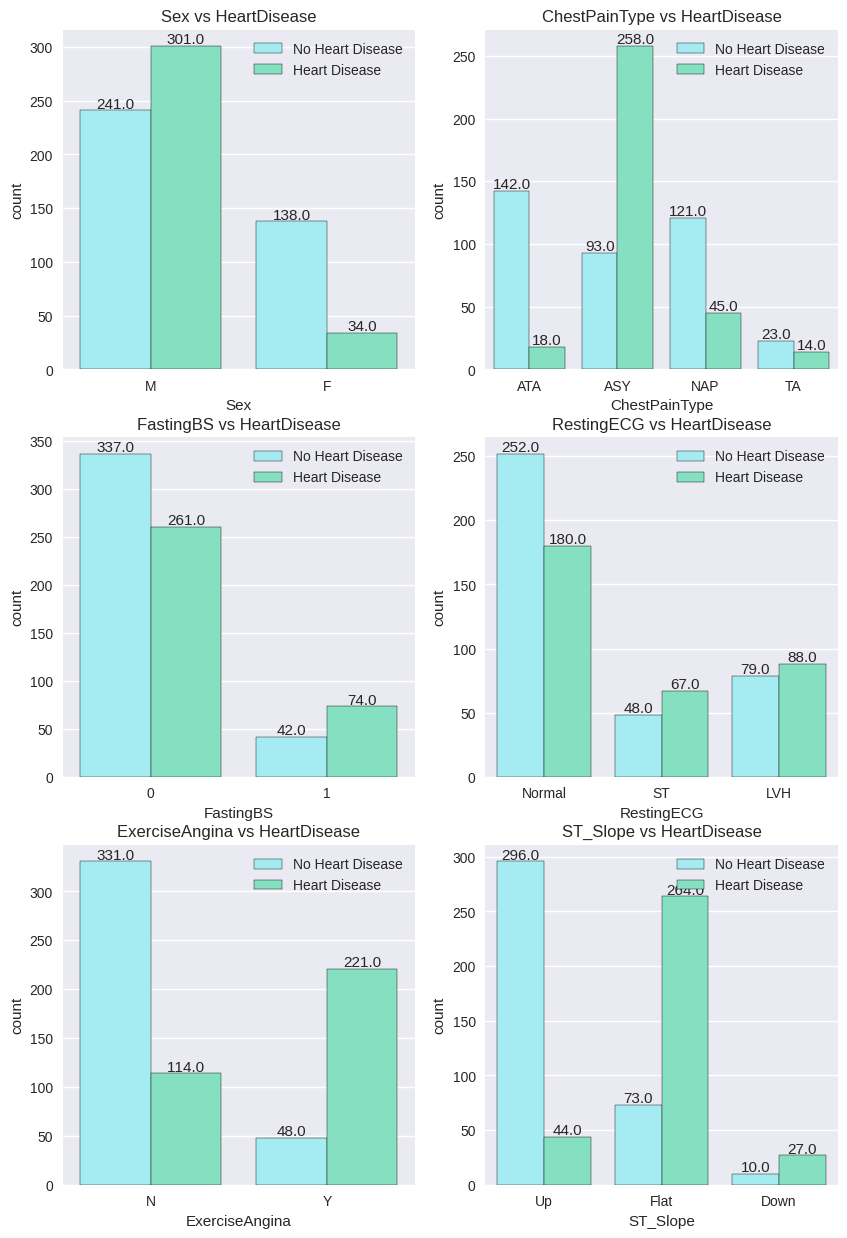

In [131]:
fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (10,15))
for i in range(len(categorical_features) - 1):
    plt.subplot(3,2,i+1)
    ax = sns.countplot(data = df,x=categorical_features[i],hue = "HeartDisease",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = categorical_features[i] + ' vs HeartDisease'
    plt.legend(['No Heart Disease','Heart Disease'])
    plt.title(title);

In [132]:
sex = df[df['HeartDisease'] == 1]['Sex'].value_counts()
sex = [sex[0] / sum(sex) * 100, sex[1] / sum(sex) * 100]

cp = df[df['HeartDisease'] == 1]['ChestPainType'].value_counts()
cp = [cp[0] / sum(cp) * 100,cp[1] / sum(cp) * 100,cp[2] / sum(cp) * 100,cp[3] / sum(cp) * 100]

fbs = df[df['HeartDisease'] == 1]['FastingBS'].value_counts()
fbs = [fbs[0] / sum(fbs) * 100,fbs[1] / sum(fbs) * 100]

restecg = df[df['HeartDisease'] == 1]['RestingECG'].value_counts()
restecg = [restecg[0] / sum(restecg) * 100,restecg[1] / sum(restecg) * 100,restecg[2] / sum(restecg) * 100]

exang = df[df['HeartDisease'] == 1]['ExerciseAngina'].value_counts()
exang = [exang[0] / sum(exang) * 100,exang[1] / sum(exang) * 100]

slope = df[df['HeartDisease'] == 1]['ST_Slope'].value_counts()
slope = [slope[0] / sum(slope) * 100,slope[1] / sum(slope) * 100,slope[2] / sum(slope) * 100]

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


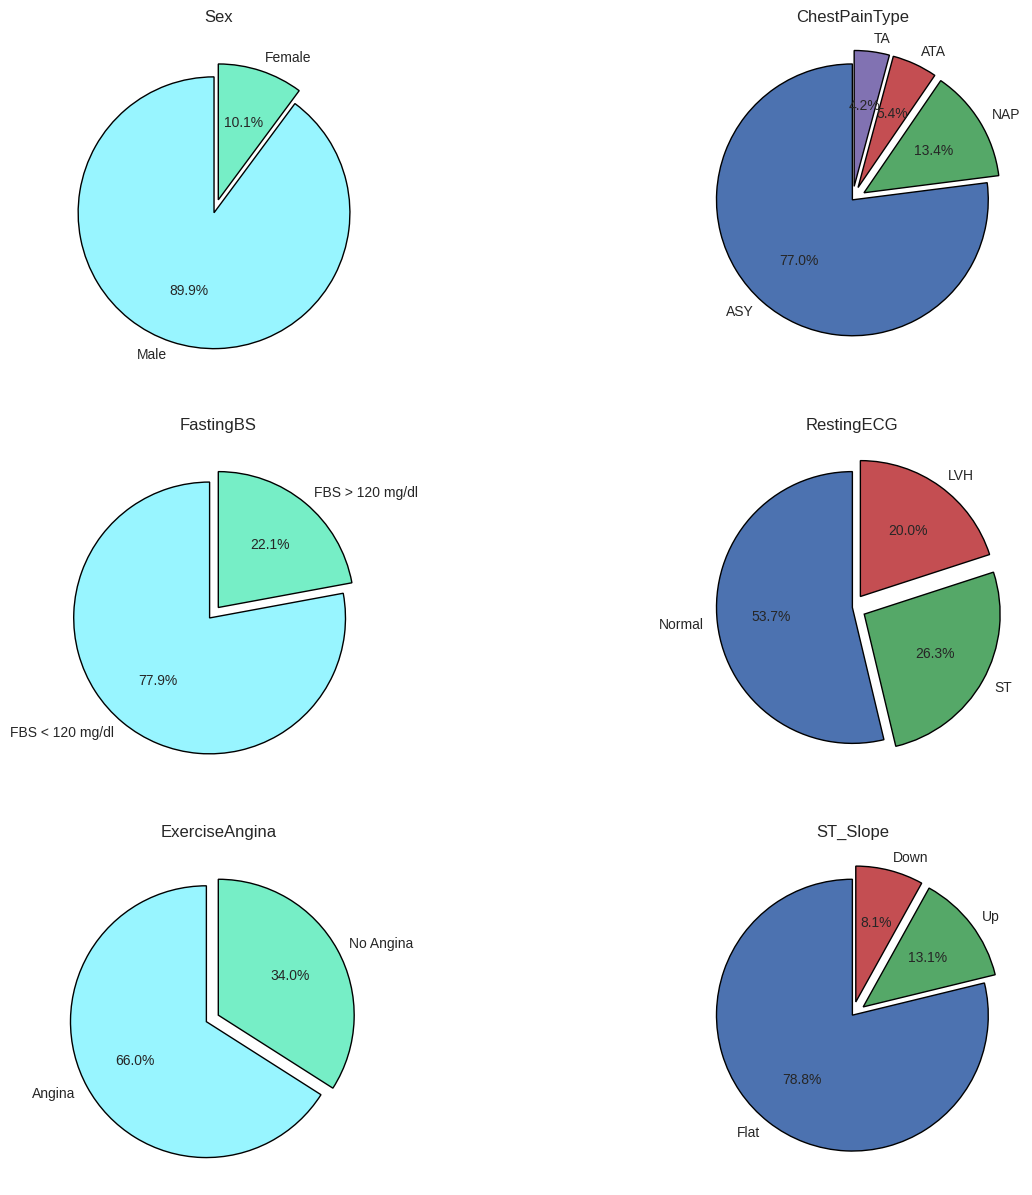

In [133]:
ax,fig = plt.subplots(nrows = 4,ncols = 2,figsize = (15,15))

plt.subplot(3,2,1)
plt.pie(sex,labels = ['Male','Female'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Sex');

plt.subplot(3,2,2)
plt.pie(cp,labels = ['ASY', 'NAP', 'ATA', 'TA'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1,0.1,0.1),
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('ChestPainType');

plt.subplot(3,2,3)
plt.pie(fbs,labels = ['FBS < 120 mg/dl','FBS > 120 mg/dl'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('FastingBS');

plt.subplot(3,2,4)
plt.pie(restecg,labels = ['Normal','ST','LVH'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1,0.1),
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('RestingECG');

plt.subplot(3,2,5)
plt.pie(exang,labels = ['Angina','No Angina'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('ExerciseAngina');

plt.subplot(3,2,6)
plt.pie(slope,labels = ['Flat','Up','Down'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1,0.1),
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('ST_Slope');

In [134]:
df['RestingBP_Group'] = [ int(i / 5) for i in df['RestingBP']]
df['Cholesterol_Group'] = [ int(i / 10) for i in df['Cholesterol']]
df['MaxHR_Group'] = [ int(i / 5) for i in df['MaxHR']]
df['Oldpeak_Group'] = [ int( (i*10) / 5) for i in df['Oldpeak']]

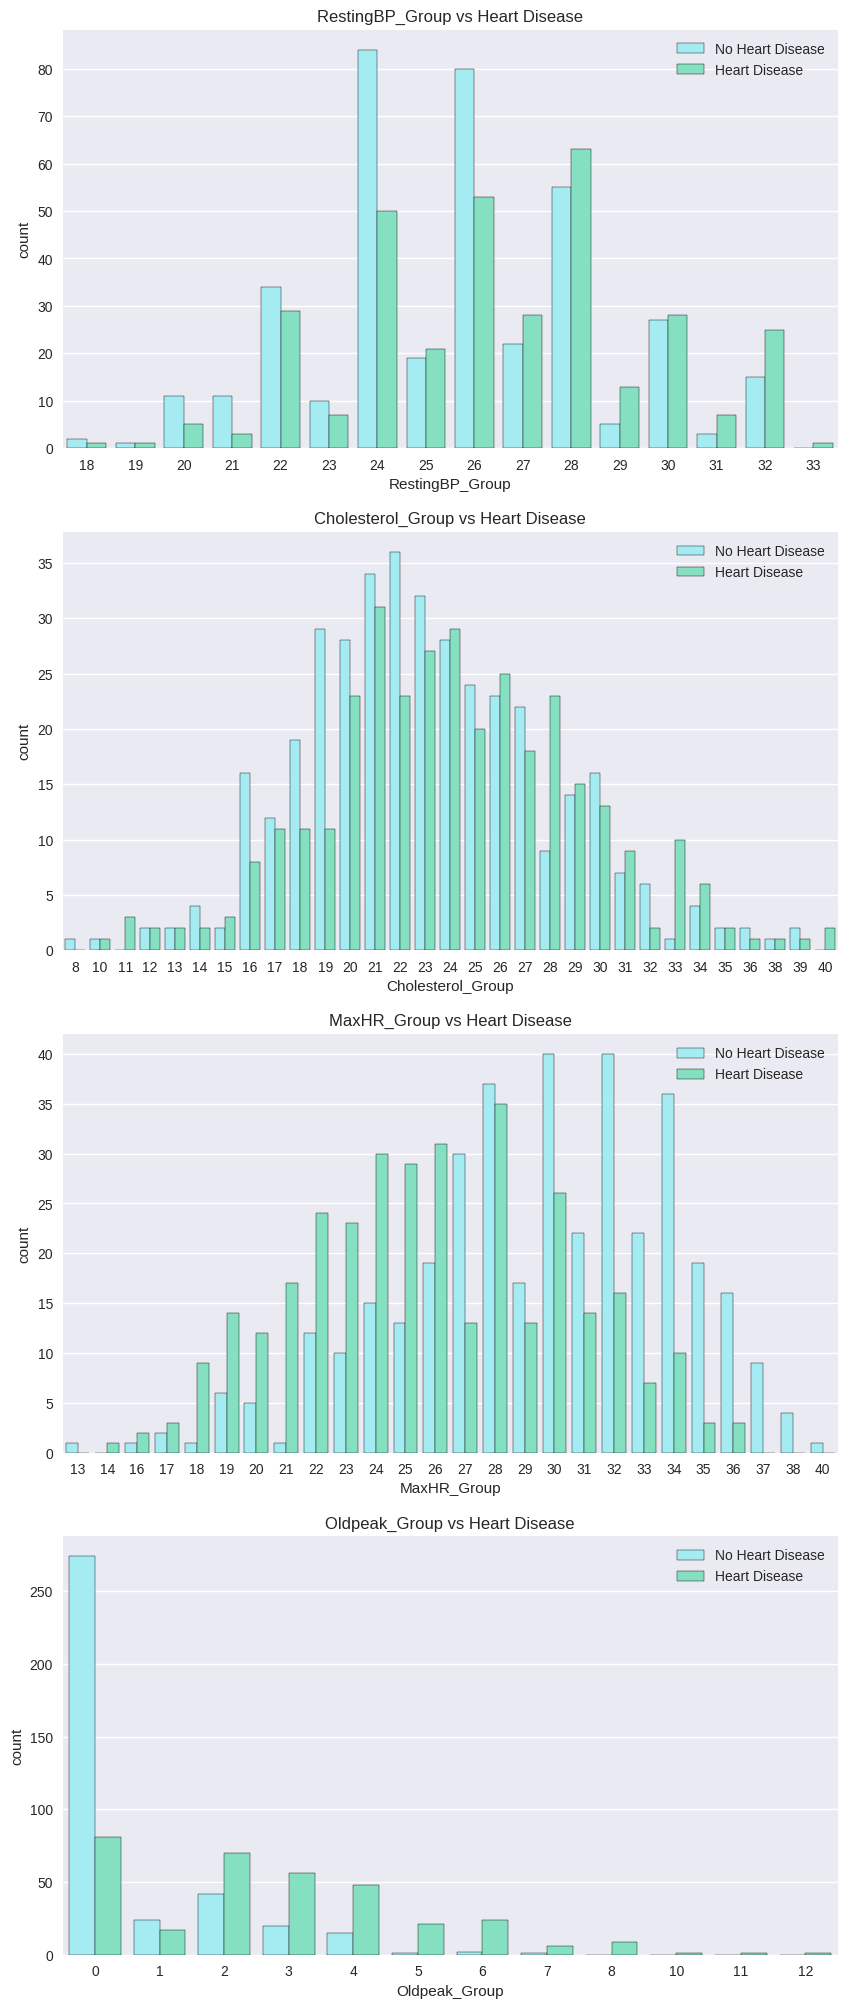

In [135]:
fig, ax = plt.subplots(nrows = 4,ncols = 1,figsize = (10,25))
group_numerical_features = [i + '_Group' for i in numerical_features[1:]]
for i in range(len(group_numerical_features)):
    plt.subplot(4,1,i+1)
    sns.countplot(data = df, x=group_numerical_features[i],hue = "HeartDisease",palette = colors, edgecolor = 'black')
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = group_numerical_features[i] + ' vs Heart Disease'
    plt.title(title);

In [136]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization
df1 = df.copy(deep = True)
df1['Oldpeak'] = mms.fit_transform(df1[['Oldpeak']])
df1['Age'] = ss.fit_transform(df1[['Age']])
df1['RestingBP'] = ss.fit_transform(df1[['RestingBP']])
df1['Cholesterol'] = ss.fit_transform(df1[['Cholesterol']])
df1['MaxHR'] = ss.fit_transform(df1[['MaxHR']])
df1.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_Group,Cholesterol_Group,MaxHR_Group,Oldpeak_Group
0,-1.337734,M,ATA,0.612417,0.973918,0,Normal,1.291921,N,0.015873,Up,0,28,28,34,0
1,-1.653588,M,ATA,-0.069638,0.854739,0,ST,-1.744958,N,0.015873,Up,0,26,28,19,0
2,-0.495457,F,ASY,0.476006,-0.515824,0,Normal,-1.334569,Y,0.253968,Flat,1,27,21,21,3
3,0.136251,M,NAP,1.294472,-0.893226,0,Normal,-0.760024,N,0.015873,Up,0,30,19,24,0
4,-1.443019,M,NAP,-0.751693,1.967080,0,Normal,1.209843,N,0.015873,Up,0,24,33,34,0


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


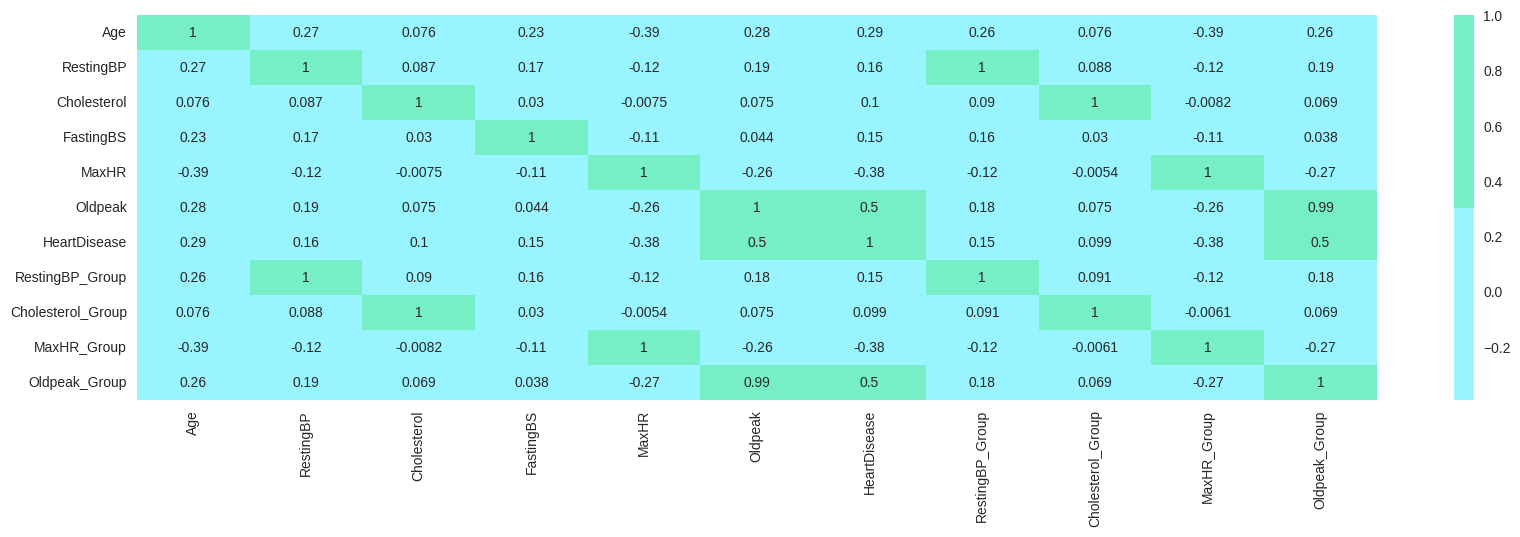

In [137]:
plt.figure(figsize = (20,5))
sns.heatmap(df1.corr(),cmap = colors,annot = True);

The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


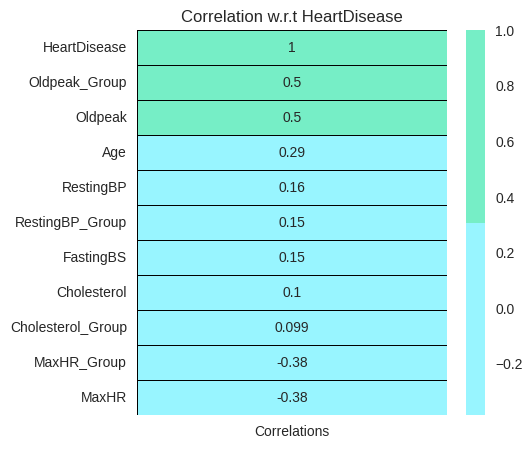

In [138]:
corr = df1.corrwith(df1['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t HeartDisease');

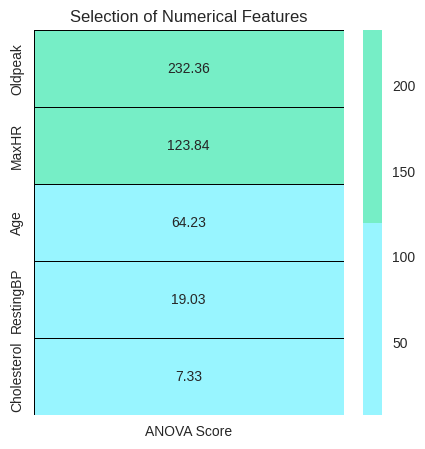

In [139]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

features = df1.loc[:,numerical_features]
target = df1.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score'])

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

In [140]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


# Separate the features and labels
X = df.drop('HeartDisease', axis=1)
X = X[categorical]
y = df['HeartDisease']

# Perform one-hot encoding on categorical features
X = pd.get_dummies(X)

selector = SelectKBest(chi2)
selector.fit(X, y)

# Perform feature selection using chi-squared test
scores = selector.scores_
feature_names = X.columns

# Print the scores and names of each feature
for i in range(len(feature_names)):
    print('Feature %s: %.3f' % (feature_names[i], scores[i]))

Feature ChestPainType_ASY: 99.611
Feature ChestPainType_ATA: 81.735
Feature ChestPainType_NAP: 26.158
Feature ChestPainType_TA: 1.225
Feature RestingECG_LVH: 2.237
Feature RestingECG_Normal: 4.785
Feature RestingECG_ST: 5.940
Feature ST_Slope_Down: 10.085
Feature ST_Slope_Flat: 133.580
Feature ST_Slope_Up: 157.607


In [141]:
features = df1.loc[:,categorical_features[:-1]]
features = pd.get_dummies(features)
target = df1.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score'])
print(featureScores)

                   Chi Squared Score
FastingBS                  13.262451
Sex_F                      50.912325
Sex_M                      16.156679
ChestPainType_ASY          99.611478
ChestPainType_ATA          81.735099
ChestPainType_NAP          26.157973
ChestPainType_TA            1.225109
RestingECG_LVH              2.236968
RestingECG_Normal           4.784783
RestingECG_ST               5.940149
ExerciseAngina_N           81.070684
ExerciseAngina_Y          134.113214
ST_Slope_Down              10.084858
ST_Slope_Flat             133.579915
ST_Slope_Up               157.607360


In [142]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import LabelEncoder

In [143]:

df1 = df_1.copy(deep = True)

mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df1['Oldpeak'] = mms.fit_transform(df1[['Oldpeak']])
df1['Age'] = ss.fit_transform(df1[['Age']])
df1['RestingBP'] = ss.fit_transform(df1[['RestingBP']])
df1['Cholesterol'] = ss.fit_transform(df1[['Cholesterol']])
df1['MaxHR'] = ss.fit_transform(df1[['MaxHR']])

In [144]:

df2 = df_2.copy(deep = True)

mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df2['Oldpeak'] = mms.fit_transform(df2[['Oldpeak']])
df2['Age'] = ss.fit_transform(df2[['Age']])
df2['RestingBP'] = ss.fit_transform(df2[['RestingBP']])
df2['Cholesterol'] = ss.fit_transform(df2[['Cholesterol']])
df2['MaxHR'] = ss.fit_transform(df2[['MaxHR']])

In [145]:
x_train = df1[df1.columns.drop(['HeartDisease'])]
cat_cols = df1.select_dtypes(include='object').columns
x_train = pd.get_dummies(x_train, columns=cat_cols)
y_train = df1['HeartDisease']
x_test = df2[df2.columns.drop(['HeartDisease'])]
x_test = pd.get_dummies(x_test, columns=cat_cols)
y_test = df2['HeartDisease']
y_train = y_train.astype(int)
y_test = y_test.astype(int)
col_names = x_train.columns

In [146]:
# Fit a Lasso regression model with l1 regularization
lasso = LassoCV(cv=KFold(n_splits=10, shuffle=True, random_state=42), random_state=42)

# Fit the LassoCV object to the training data
lasso.fit(x_train, y_train)

# Print the optimal alpha value
print('Optimal alpha:', lasso.alpha_)
#lasso = Lasso(alpha=0.01)
#lasso.fit(x_train, y_train)

# Evaluate the performance of the Lasso model
y_pred = lasso.predict(x_test)
y_pred_rounded = y_pred.round().astype(int)
print('F1-score:', f1_score(y_test, y_pred_rounded))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred_rounded))
print('Lasso Coefficients:')
for col, coef in zip(x_train.columns, lasso.coef_):
    print('{}: {:.8f}'.format(col, coef))

Optimal alpha: 0.0012397673019841735
F1-score: 0.8669527896995709
Balanced Accuracy: 0.8104422604422605
Lasso Coefficients:
Age: 0.02956030
RestingBP: 0.00133135
Cholesterol: -0.05620236
FastingBS: 0.10433601
MaxHR: -0.01133407
Oldpeak: 0.37053704
Sex_F: -0.16442671
Sex_M: 0.00000000
ChestPainType_ASY: 0.22348325
ChestPainType_ATA: -0.04330687
ChestPainType_NAP: -0.00790280
ChestPainType_TA: 0.03595320
RestingECG_LVH: 0.00737852
RestingECG_Normal: 0.00000000
RestingECG_ST: -0.00213084
ExerciseAngina_N: -0.13461971
ExerciseAngina_Y: 0.00000000
ST_Slope_Down: 0.00000000
ST_Slope_Flat: 0.14208986
ST_Slope_Up: -0.22515641


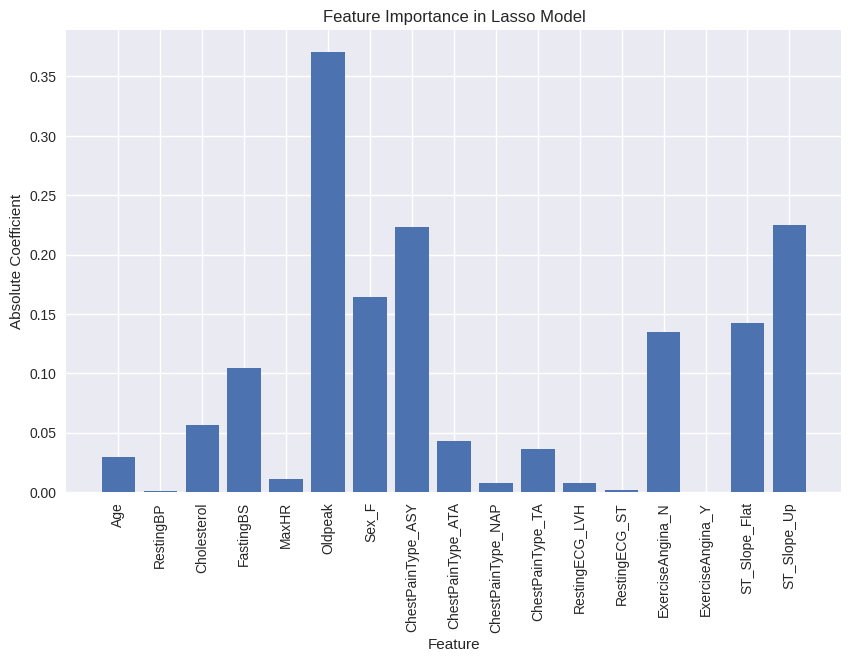

In [147]:
import matplotlib.pyplot as plt

# Get the feature coefficients corresponding to the important features
important_coef = lasso.coef_[lasso.coef_ != 0]
important_features = x_train.columns[lasso.coef_ != 0]
# Plot the absolute value of the feature coefficients against the feature names
plt.figure(figsize=(10, 6))
plt.bar(important_features, abs(important_coef))
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Absolute Coefficient')
plt.title('Feature Importance in Lasso Model')
plt.show()

In [148]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
decision = DecisionTreeClassifier(criterion="gini", random_state=1)
decision.fit(x_train, y_train)
y_pred_Decision = decision.predict(x_test)

decision_train = round(decision.score(x_train, y_train) * 100, 2)
decision_accuracy = round(accuracy_score(y_pred_Decision, y_test) * 100, 2)
decision_f1 = round(f1_score(y_pred_Decision, y_test) * 100, 2)

print("Training Accuracy     :",decision_train,"%")
print("Model Accuracy Score  :",decision_accuracy,"%")
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred_Decision))
print("Classification_Report: \n",classification_report(y_test,y_pred_Decision))

Training Accuracy     : 100.0 %
Model Accuracy Score  : 73.37 %
Confusion Matrix: 
 [[39 35]
 [14 96]]
Classification_Report: 
               precision    recall  f1-score   support

           0       0.74      0.53      0.61        74
           1       0.73      0.87      0.80       110

    accuracy                           0.73       184
   macro avg       0.73      0.70      0.71       184
weighted avg       0.73      0.73      0.72       184



Text(0.5, 1.0, 'Feature Importance Scores (Gini): Decision Tree')

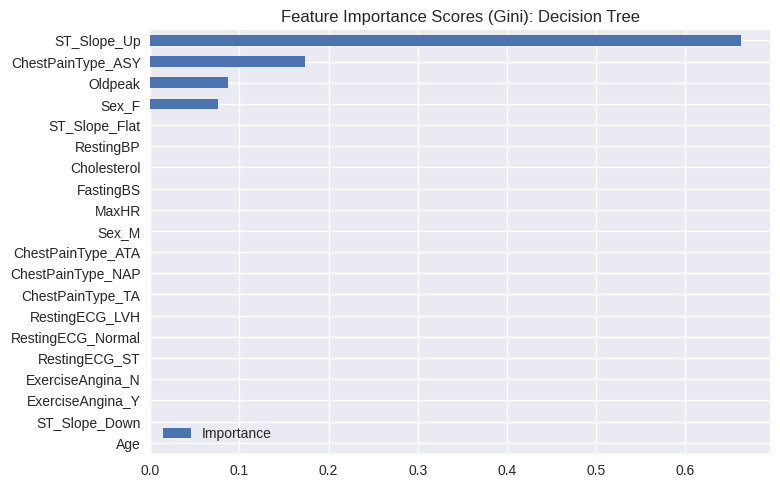

In [149]:
from sklearn.model_selection import GridSearchCV
grid = {"max_depth": np.arange(1,8),"min_samples_leaf": 2**np.arange(0,7)}
cv = GridSearchCV(estimator=decision, param_grid=grid, scoring="f1", cv=5)
cv.fit(x_train, y_train)
opt_tree = cv.best_estimator_
ft_importances = pd.DataFrame({"Importance": opt_tree.feature_importances_},index = x_train.columns)
ft_importances = ft_importances.sort_values(by="Importance")
ft_importances = ft_importances
ft_importances.plot.barh()
plt.title("Feature Importance Scores (Gini): Decision Tree")

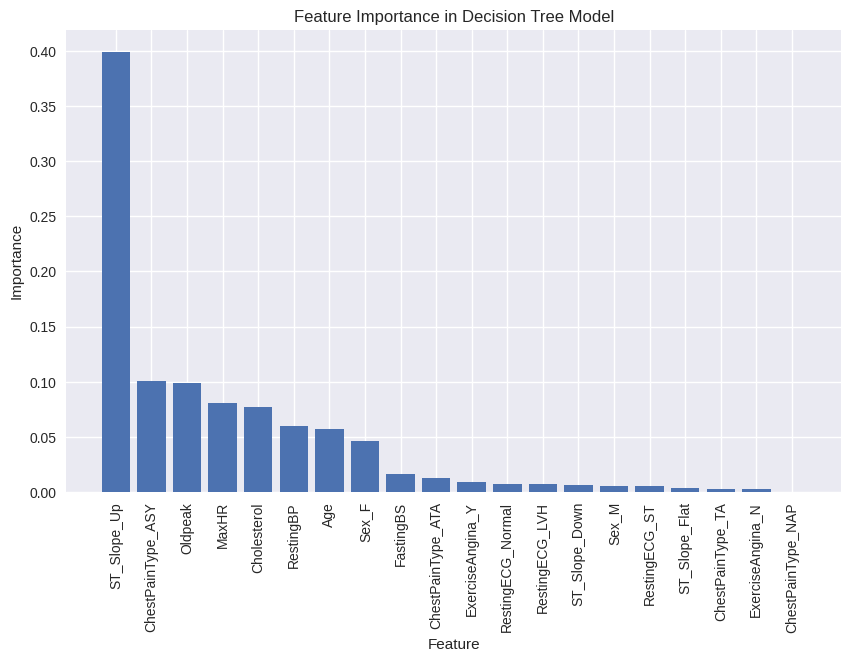

In [150]:
importances = decision.feature_importances_
indices = np.argsort(importances)[::-1]
features = x_train.columns

# Plot the feature importances
plt.figure(figsize=(10,6))
plt.bar(range(x_train.shape[1]), importances[indices])
plt.xticks(range(x_train.shape[1]), features[indices],rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance in Decision Tree Model')
plt.show()

In [151]:
# import numpy as np
# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.optimizers import Adam
# from sklearn.metrics import accuracy_score
#
# # Define the MLP model architecture
# model = Sequential()
# model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
#
# # Compile the model with binary cross-entropy loss and Adam optimizer
# model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
#
# # Train the model on the entire dataset
# history = model.fit(X, y, epochs=50, batch_size=16, verbose=0)
#
# # Evaluate the model on the entire dataset
# y_pred = model.predict(X)
# y_pred = np.round(y_pred).astype(int)
# train_acc = accuracy_score(y, y_pred)
#
# # Print the training set accuracy
# print("Training set accuracy:", train_acc)


In [152]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
model = MLPClassifier(hidden_layer_sizes = (64,32), activation = 'logistic', max_iter=2000)
model = model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.72      0.77        74
           1       0.83      0.91      0.87       110

    accuracy                           0.83       184
   macro avg       0.83      0.81      0.82       184
weighted avg       0.83      0.83      0.83       184



In [153]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class HeartDiseaseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size, hidden_size, p_drop, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.drop1 = nn.Dropout(p=p_drop)
        self.drop2 = nn.Dropout(p=p_drop)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.sm  = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.drop1(x)
        x = self.relu2(self.layer2(x))
        x = self.drop2(x)
        x = self.layer3(x)
        x = self.sm(x)
        return x

input_size = x_train.shape[1]
hidden_size = 10
p_drop = 0.1
output_size = 1
batch_size = 32
num_epochs = 100

X = torch.tensor(x_train.values, dtype=torch.float)
y = torch.tensor(y_train.values, dtype=torch.float)
y = y.reshape(-1, 1)

dataset = HeartDiseaseDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = HeartDiseaseModel(input_size, hidden_size, p_drop, output_size)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

model.train()

for epoch in range(num_epochs+1):
  for batch_idx, (data, targets) in enumerate(dataloader):
    data = data.to(device)
    targets = targets.to(device)

    scores = model(data)
    loss = criterion(scores, targets)
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

  if epoch % 10 == 0:
    model.eval()
    y_pred = model(X)
    acc = np.mean(np.round(y_pred.detach().numpy())==y.detach().numpy())
    print("Ep.", epoch, "; Train Acc =", np.round(100*acc, 1), "%")
    model.train()

model.eval()
y_pred_prob = model(torch.tensor(x_test.values, dtype=torch.float)).detach().numpy()
y_pred = np.round(y_pred_prob)

print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=["HD=0", "HD=1"]))

Ep. 0 ; Train Acc = 79.0 %
Ep. 10 ; Train Acc = 85.8 %
Ep. 20 ; Train Acc = 87.9 %
Ep. 30 ; Train Acc = 88.4 %
Ep. 40 ; Train Acc = 89.0 %
Ep. 50 ; Train Acc = 89.0 %
Ep. 60 ; Train Acc = 89.2 %
Ep. 70 ; Train Acc = 90.3 %
Ep. 80 ; Train Acc = 90.9 %
Ep. 90 ; Train Acc = 91.1 %
Ep. 100 ; Train Acc = 92.0 %
              precision    recall  f1-score   support

        HD=0       0.88      0.70      0.78        74
        HD=1       0.82      0.94      0.88       110

    accuracy                           0.84       184
   macro avg       0.85      0.82      0.83       184
weighted avg       0.85      0.84      0.84       184



In [ ]:
!pip install shap
import shap

# Using Deep Explainer after the discussion with colleagues post multiple failed attempts
explainer = shap.DeepExplainer(model, torch.from_numpy(x_train.values).float())
shap_values = explainer.shap_values(torch.from_numpy(x_test.values).float())

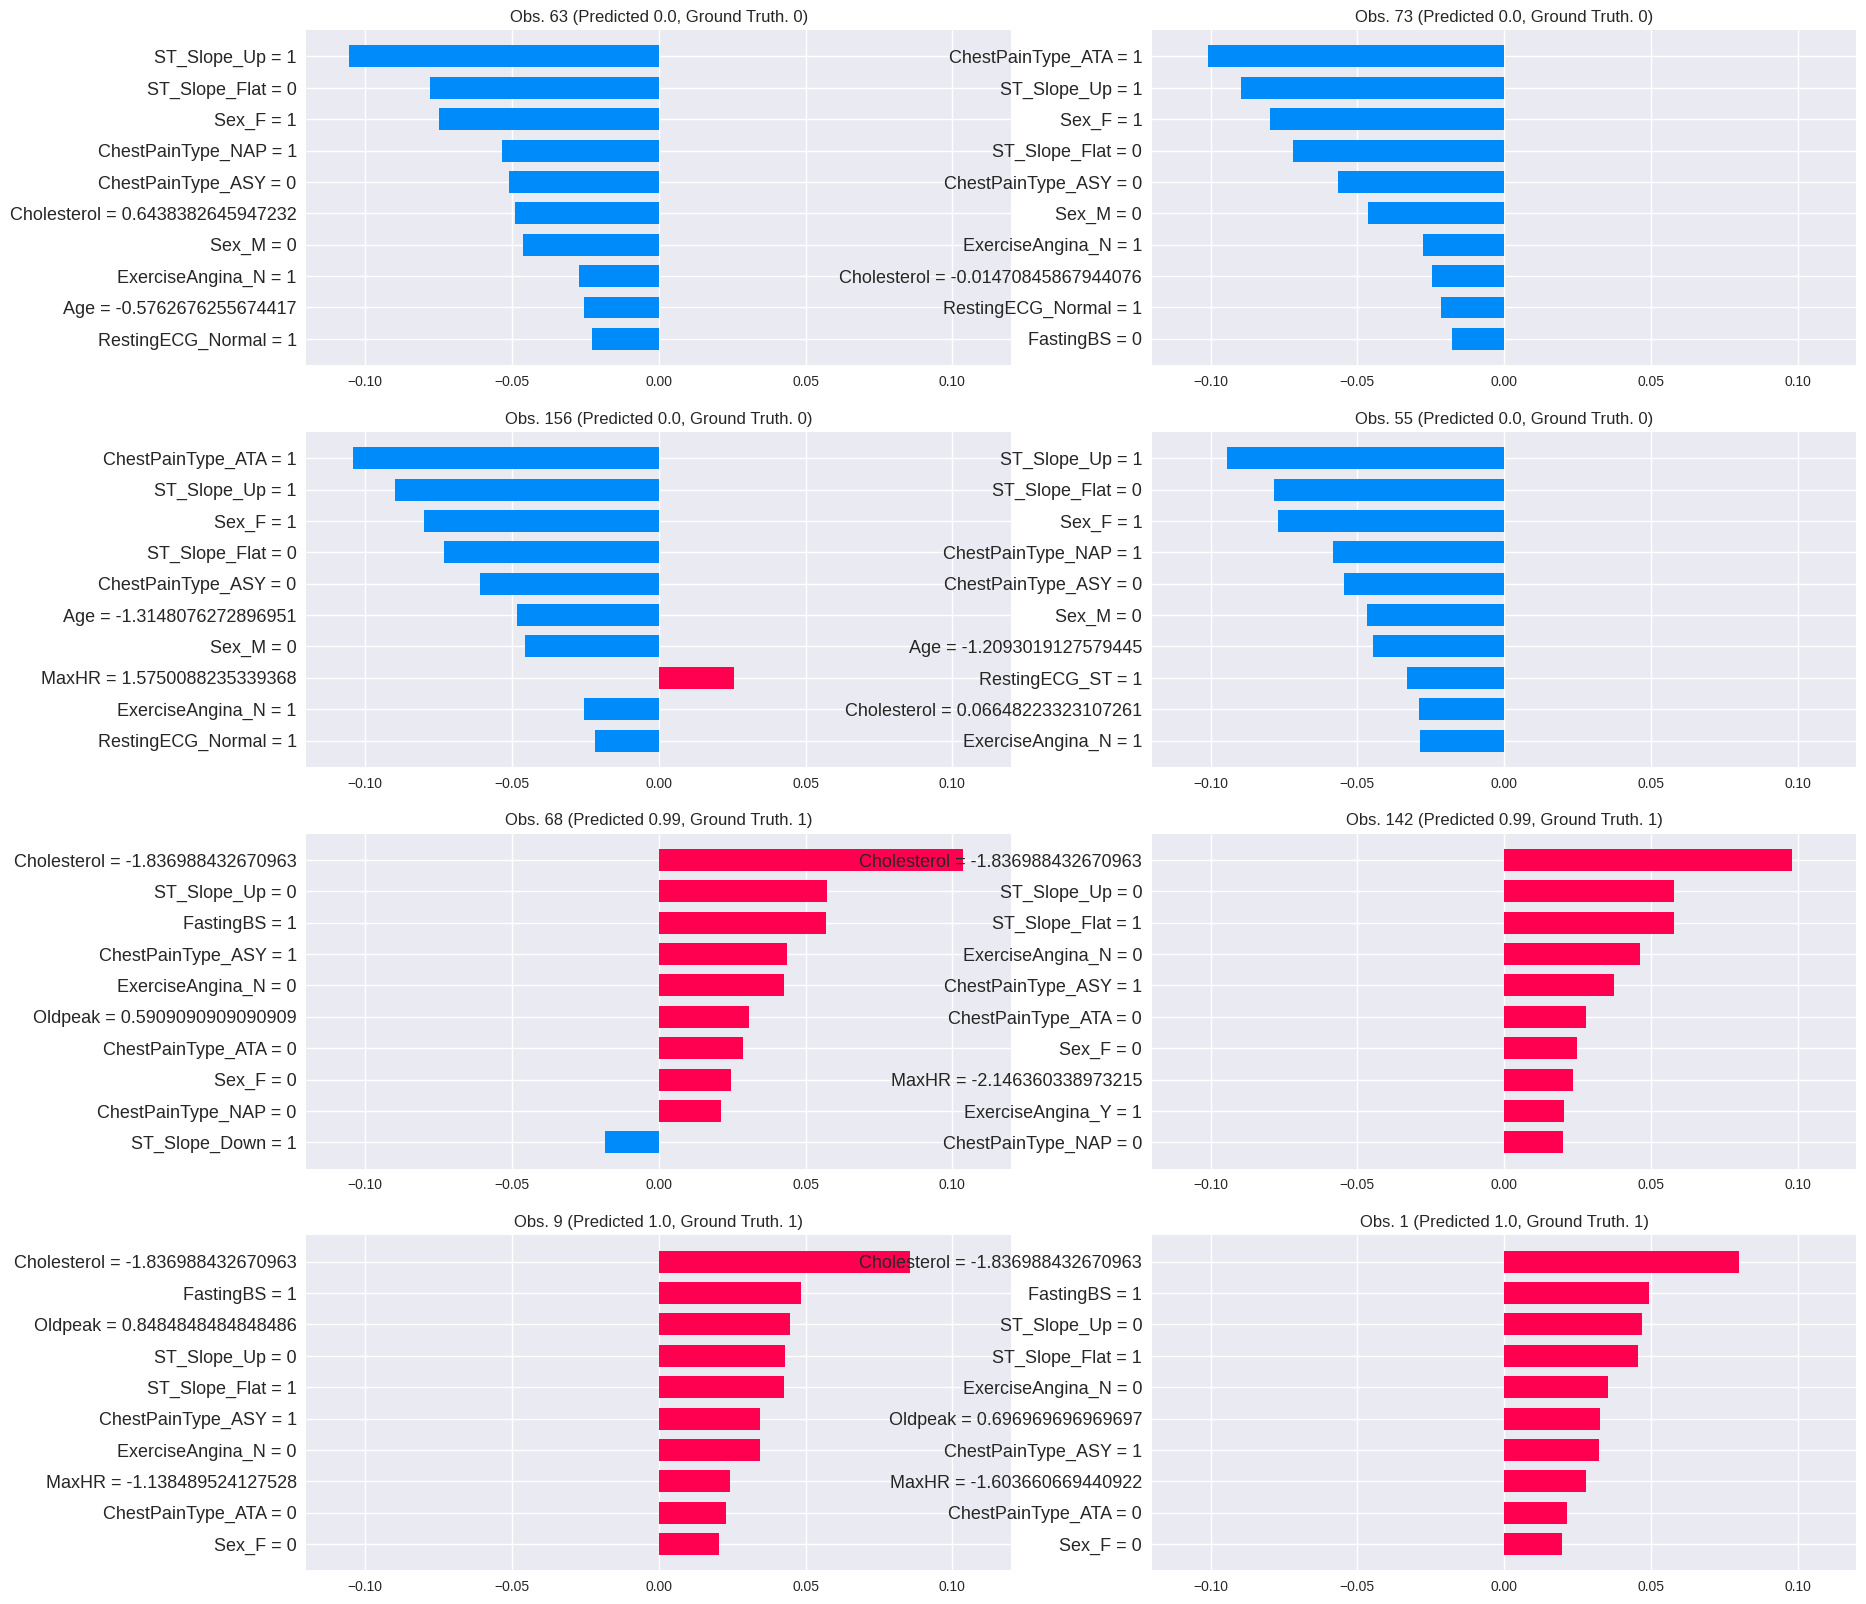

In [155]:
import matplotlib.pyplot as plt
import numpy as np
import shap

# Define custom color palette
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

pos_obs = np.argsort(y_pred_prob[:,0])[:4]
neg_obs = np.argsort(y_pred_prob[:,0])[-4:]
ind = np.concatenate((pos_obs, neg_obs))

plt.figure(figsize=(20, 20))
for i, obs in enumerate(ind):
    ax = plt.subplot(4, 2, i+1)
    ax.set_title("Obs. " + str(obs) + " (Predicted " + str(np.round(y_pred_prob[obs,0], 2)) + ", Ground Truth. " + str(y_test[obs]) + ")")
    shap.bar_plot(shap_values[obs], x_test.values[obs], feature_names = col_names, show=False, max_display=10)
    plt.xlabel("")
    plt.xlim(-0.12, 0.12)

